In [67]:
%matplotlib inline
from config_calc import *
import grid_tools
from glob import glob

import xarray as xr
import numpy as np

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import colorbrewer

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


XN2 = 0.7808
XO2 = 0.2095

In [48]:
#from dask.distributed import Client
#client = Client(scheduler_file=os.path.join('/glade/scratch',os.environ['USER'],
#                                            'dask/scheduler.json'))
#client

In [82]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['Z3','Q','PS','PBLH','T','U','V','U10','PSL','OMEGA']+tracer_3d

diri = os.path.join(dataroot,'orcas','cesm_flight_data')
model_files = [os.path.join(diri,'.'.join([case,os.path.basename(f)])) 
              for f in gv.flight_file]

obs = xr.open_mfdataset(gv.flight_file)
mdl = xr.open_mfdataset(model_files)

model_n2_files = sorted(glob('/glade/work/mclong/orcas/flt_mdl_col/*.aN2_OCN.*'))
mdl_n2 = xr.open_mfdataset(model_n2_files)
mdl = xr.merge((mdl, mdl_n2))

obs['GGALT'] = obs.GGALT * 1e-3
obs.GGALT.attrs['units'] = 'km'
obs = obs.drop(['UTC','DOY'])


mdl['O2N2_OCN'] = (mdl['O2_OCN'] - 
                   1.1 * mdl['CO2_LND']/XO2 - 
                   1.4 * mdl['CO2_FFF']/XO2 - 
                   mdl['aN2_OCN_abio1850']/XN2)

mdl['O2N2_GKA'] = (mdl['O2_GKA'] - 
                   1.1 * mdl['CO2_LND']/XO2 - 
                   1.4 * mdl['CO2_FFF']/XO2 - 
                   mdl['aN2_OCN_abio1850']/XN2)

                   
mdl['GGALT'] = obs.GGALT.copy()
mdl['GGLAT'] = obs.GGLAT.copy()
mdl['GGLON'] = obs.GGLON.copy()
mdl = mdl.drop(['UTC','DOY'])
mdl.info()

xarray.Dataset {
dimensions:
	time = 35732 ;

variables:
	datetime64[ns] time(time) ;
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		C

### Apply a mask to avoid land and points north of latitude boundary

mask points over land

In [83]:
lat_rgn = [-90.,-44]
lon_rgn = [-180.,180.]

named_points = {
    'SCCI' : [-53.01062,-70.85168,42],
    'SCAR' : [-18.3483,-70.3386, 167],
    'SCTE' : [-41.438611, -73.0939, 294],
    'SCVD' : [-39.649722,-73.086111,59]}

airport_lon = np.array([v[1] for v in named_points.values()])
airport_lat = np.array([v[0] for v in named_points.values()])

def region_quality_mask(x,y,z):
    from earth_geometry import points_in_range

    #-- land_mask = within 10km of airport and below 4 km
    land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )

    #-- region_mask 
    region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )

    return ( land_mask & region_mask )


Verify application of mask: points in orange are included, points in blue have been removed

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/gpfs/u/home/mclong/p/orcas/earth_geometry.py:57: RuntimeWarning: invalid value encountered in less_equal
  mask = np.array((haversine(clon,clat,plon.ravel(),plat.ravel()) <= range_km))
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


Text(0, 0.5, 'Altitude')

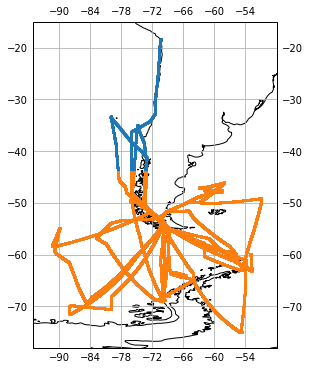

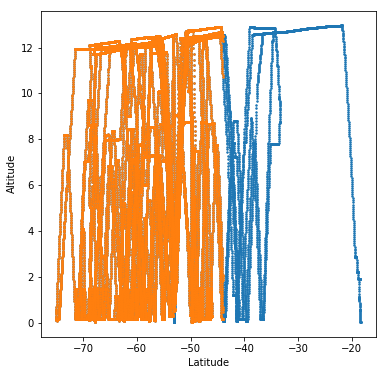

In [84]:
fig = plt.figure(figsize=(6,6))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(111,projection=crs_latlon)
ax.set_extent([-95,-48,-78,-15],crs=crs_latlon)
ax.coastlines('50m')
ax.gridlines(draw_labels=True)

ax.plot(mdl.GGLON,mdl.GGLAT,'.',markersize=3,transform=crs_latlon)
ds = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
ax.plot(ds.GGLON,ds.GGLAT,'.',markersize=3,transform=crs_latlon)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(mdl.GGLAT,mdl.GGALT,'.',markersize=3)
ax.plot(ds.GGLAT,ds.GGALT,'.',markersize=3)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude')

Apply the mask

In [85]:
mdl = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
obs = obs.where(region_quality_mask(obs.GGLON.values,obs.GGLAT.values,obs.GGALT.values))

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


### bin the data into altitude bins

In [86]:
%%time
alt_bins = np.concatenate((np.arange(0.,1.,0.25),np.arange(1.,14.5,0.5)))
alt_bin_c = np.vstack((alt_bins[0:-1],alt_bins[1:])).mean(axis=0)

groups = mdl.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
mdl_avg = groups.mean()
mdl_std = groups.std()

groups = obs.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
obs_avg = groups.mean()
obs_std = groups.std()
  
mdl_avg.info()

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


xarray.Dataset {
dimensions:
	GGALT_bins = 30 ;

variables:
	float64 GGALT_bins(GGALT_bins) ;
	float64 O2_OCN(GGALT_bins) ;
	float64 CO2_T09k(GGALT_bins) ;
	float64 aO2_GKA(GGALT_bins) ;
	float64 CO2_C15O(GGALT_bins) ;
	float64 CO2_LND(GGALT_bins) ;
	float64 U10(GGALT_bins) ;
	float64 CO2_T09(GGALT_bins) ;
	float64 PS(GGALT_bins) ;
	float64 CO2_T09b(GGALT_bins) ;
	float64 CO2_T09c(GGALT_bins) ;
	float64 CO2_T09d(GGALT_bins) ;
	float64 CO2_T09e(GGALT_bins) ;
	float64 CO2_T09f(GGALT_bins) ;
	float64 CO2_T09g(GGALT_bins) ;
	float64 CO2_T09h(GGALT_bins) ;
	float64 CO2_T09i(GGALT_bins) ;
	float64 CO2_T09j(GGALT_bins) ;
	float64 CO2_CROF(GGALT_bins) ;
	float64 CO2_T09l(GGALT_bins) ;
	float64 CO2_OCN(GGALT_bins) ;
	float64 CO2_CROT(GGALT_bins) ;
	float64 Pm(GGALT_bins) ;
	float64 OMEGA(GGALT_bins) ;
	float64 CO2_L14C(GGALT_bins) ;
	float64 Z3(GGALT_bins) ;
	float64 PBLH(GGALT_bins) ;
	float64 CO2_T09a(GGALT_bins) ;
	float64 CO2_CROO(GGALT_bins) ;
	float64 Q(GGALT_bins) ;
	float64 U(GGALT_bins

### Plot alt-bin averaged, normalized profiles

In [87]:
#normalize_alt = [12.,99.]
normalize_alt = [7.5,8.5]
#normalize_alt = [5.5,6.5]
normalize = lambda da: (da - 
                        da.where((da.GGALT_bins>normalize_alt[0]) &
                                 (da.GGALT_bins<normalize_alt[1])).mean())    
mdl_avg.GGALT_bins

<xarray.DataArray 'GGALT_bins' (GGALT_bins: 30)>
array([ 0.125,  0.375,  0.625,  0.875,  1.25 ,  1.75 ,  2.25 ,  2.75 ,  3.25 ,
        3.75 ,  4.25 ,  4.75 ,  5.25 ,  5.75 ,  6.25 ,  6.75 ,  7.25 ,  7.75 ,
        8.25 ,  8.75 ,  9.25 ,  9.75 , 10.25 , 10.75 , 11.25 , 11.75 , 12.25 ,
       12.75 , 13.25 , 13.75 ])
Coordinates:
  * GGALT_bins  (GGALT_bins) float64 0.125 0.375 0.625 ... 12.75 13.25 13.75

In [88]:
color = {'CO2_NOAA' : colorbrewer.singlehue('red')[2],
         'CO2': colorbrewer.singlehue('blue')[4],
         'CO2_OCN': colorbrewer.singlehue('blue')[2],
         'CO2_FFF': colorbrewer.singlehue('red')[2],
         'CO2_LND': colorbrewer.singlehue('green')[1],
         'CO2_T09': colorbrewer.singlehue('red')[0],
         'CO2_L14C':colorbrewer.singlehue('orange')[4],
         'CO2_C15O':colorbrewer.singlehue('black')[0]}

alt_flux_tracers = ['CO2_L14C','CO2_T09','CO2_OCN']#,'CO2_C15O']

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/reductions.py:408: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


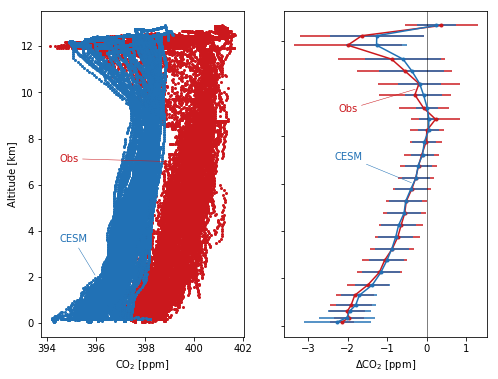

In [89]:
fig = plt.figure(figsize=(8.,6.))
vm = 'CO2'
vo = 'CO2_NOAA'
color_mdl = colorbrewer.singlehue('blue')[2]
color_obs = colorbrewer.singlehue('red')[2]

ax = fig.add_subplot(121)
sc = ax.plot(obs[vo],obs.GGALT,'.',markersize=4,color=color_obs)
sc = ax.plot(mdl[vm],mdl.GGALT,'.',markersize=4,color=color_mdl)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

ax.annotate('Obs', 
    xy=(399,7), 
    xytext=(394.5,7),
    color=color_obs,
    arrowprops=dict(color=color_obs,arrowstyle='-',linewidth=0.5))

ax.annotate('CESM', 
            xy=(396,2), 
            xytext=(394.5,3.5),
            color=color_mdl,
            arrowprops=dict(color=color_mdl,arrowstyle='-',linewidth=0.5))

ax = fig.add_subplot(122)
sc = ax.errorbar(normalize(obs_avg[vo]).values,
                 obs_avg.GGALT.values,
                 xerr=obs_std[vo].values,
                 fmt='.-',color=color_obs)

sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                 mdl_avg.GGALT.values,
                 xerr=mdl_std[vm].values,
                 fmt='.-',color=color_mdl)

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_yticklabels([])

label = {'CO2':{'y':6,'xoff':-2.0,'yoff':1,'name':'CESM'},
         'CO2_NOAA':{'y':10,'xoff':-2.,'yoff':-1,'name':'Obs'}}
for vm,lb in label.items():
    if 'NOAA' in vm:
        x = np.interp(lb['y'],obs_avg.GGALT.values,normalize(obs_avg[vm]).values)
        ax.annotate(lb['name'], 
            xy=(x,lb['y']), 
            xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
            color=color_obs,
            arrowprops=dict(color=color_obs,arrowstyle='-',linewidth=0.5))
    else:
        x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
        ax.annotate(lb['name'], 
                    xy=(x,lb['y']), 
                    xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                    color=color_mdl,
                    arrowprops=dict(color=color_mdl,arrowstyle='-',linewidth=0.5))

plt.savefig(os.path.join(diro['fig'],'raw-co2-to-bin-avg-norm.pdf'),bbox_inches='tight')

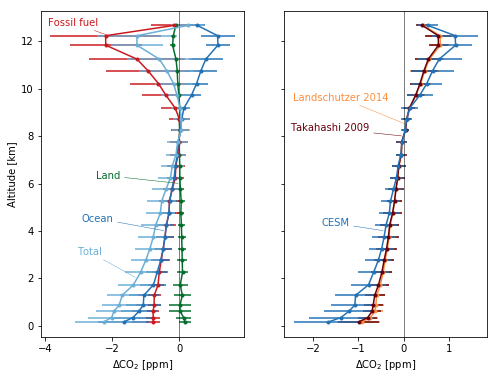

In [90]:
fig = plt.figure(figsize=(8.,6.))

#-- plot composition
ax = fig.add_subplot(121)
for vm in ['CO2_LND','CO2_FFF','CO2_OCN','CO2']:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])
    
ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

label = {'CO2_FFF':{'y':12.25,'xoff':-1.8,'yoff':0.4,'name':'Fossil fuel'},
         'CO2_LND':{'y':6,'xoff':-2.5,'yoff':0.2,'name':'Land'},
         'CO2_OCN':{'y':4,'xoff':-2.5,'yoff':0.4,'name':'Ocean'},         
         'CO2':{'y':2,'xoff':-1.8,'yoff':1,'name':'Total'}         
        }
for vm,lb in label.items():
    x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )

ax = fig.add_subplot(122)

for vm in alt_flux_tracers:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_yticklabels([])

label = {'CO2_L14C':{'y':8.5,'xoff':-2.5,'yoff':1,'name':'Landschutzer 2014'},
         'CO2_T09':{'y':8,'xoff':-2.5,'yoff':0.2,'name':'Takahashi 2009'},
         'CO2_C15O':{'y':11,'xoff':-3.2,'yoff':0.2,'name':'CarbonTracker 2015'},         
         'CO2_OCN':{'y':4,'xoff':-1.4,'yoff':0.2,'name':'CESM'}         
        }
for vm,lb in label.items():
    if vm not in alt_flux_tracers: continue
    x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )
plt.savefig(os.path.join(diro['fig'],'vertical-profile-flavors-alt-fluxes.pdf'),
           bbox_inches='tight',dpi=300)

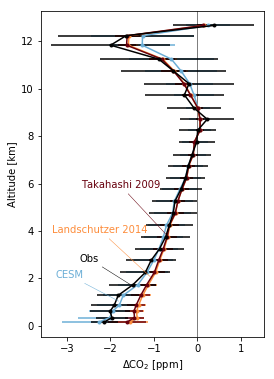

In [91]:
fig = plt.figure(figsize=(4.,6.))

#-- plot composition
ax = fig.add_subplot(111)
for vm in ['CO2','CO2_L14C','CO2_T09']:
    x = normalize(mdl_avg[vm])
    if vm in ['CO2_L14C','CO2_T09']:
        x += normalize(mdl_avg.CO2_FFF) + normalize(mdl_avg.CO2_LND)

    sc = ax.errorbar(x.values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])

sc = ax.errorbar(normalize(obs_avg[vo]).values,
                 obs_avg.GGALT.values,
                 xerr=obs_std[vo].values,
                 fmt='.-',color=colorbrewer.singlehue('black')[0])
    
ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

label = {'CO2':{'y':1,'xoff':-1.5,'yoff':1,'name':'CESM'},
         'CO2_L14C':{'y':2,'xoff':-2.3,'yoff':1.9,'name':'Landschutzer 2014'},
         'CO2_T09':{'y':3.8,'xoff':-2.0,'yoff':2,'name':'Takahashi 2009'}       
        }

for vm,lb in label.items():
    x = normalize(mdl_avg[vm])
    if vm in ['CO2_L14C','CO2_T09']:
        x += normalize(mdl_avg.CO2_FFF) + normalize(mdl_avg.CO2_LND)
    x = np.interp(lb['y'],mdl_avg.GGALT.values,x.values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )

y = 1.7
x = np.interp(y,obs_avg.GGALT.values,normalize(obs_avg[vo]).values)
ax.annotate('Obs', 
            xy=(x,y), 
            xytext=(x-1.2,y+1),
            color=colorbrewer.singlehue('black')[0],
            arrowprops=dict(color=colorbrewer.singlehue('black')[0],arrowstyle='-',linewidth=0.5),
            )

plt.savefig(os.path.join(diro['fig'],'vertical-profile-flavors-alt-fluxes-single-panel.pdf'),
           bbox_inches='tight',dpi=300)

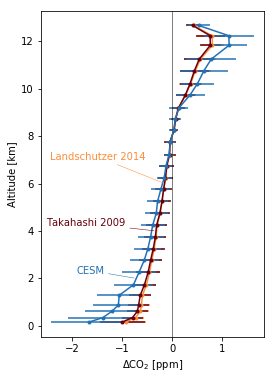

In [92]:
fig = plt.figure(figsize=(4.,6.))

ax = fig.add_subplot(111)

for vm in alt_flux_tracers:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

label = {'CO2_L14C':{'y':6,'xoff':-2.3,'yoff':1,'name':'Landschutzer 2014'},
         'CO2_T09':{'y':4,'xoff':-2.2,'yoff':0.2,'name':'Takahashi 2009'},
         'CO2_C15O':{'y':11,'xoff':-3.,'yoff':0.2,'name':'CarbonTracker 2015'},         
         'CO2_OCN':{'y':2,'xoff':-1.2,'yoff':0.2,'name':'CESM'}         
        }
for vm,lb in label.items():
    if vm not in alt_flux_tracers: continue
    x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )
plt.savefig(os.path.join(diro['fig'],'vertical-profile-alt-fluxes.pdf'),
           bbox_inches='tight',dpi=300)

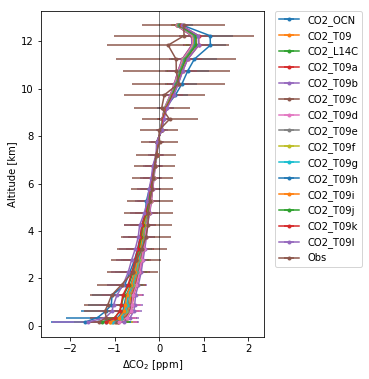

In [93]:
fig = plt.figure(figsize=(4.,6.))

ax = fig.add_subplot(111)

co2_ocn = ['CO2_OCN', 'CO2_T09', 'CO2_L14C',
           'CO2_T09a', 'CO2_T09b', 'CO2_T09c', 
           'CO2_T09d', 'CO2_T09e', 'CO2_T09f', 'CO2_T09g', 
           'CO2_T09h', 'CO2_T09i', 'CO2_T09j', 'CO2_T09k', 
           'CO2_T09l']
for vm in co2_ocn:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',label=vm)

sc = ax.errorbar(normalize(obs_avg.CO2_NOAA-mdl_avg.CO2_FFF).values,
                 obs_avg.GGALT.values,
                 xerr=obs_std.CO2_NOAA.values,
                 fmt='.-',label='Obs') 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

plt.savefig(os.path.join(diro['fig'],'vertical-profile-alt-fluxes-all.pdf'),
           bbox_inches='tight',dpi=300)

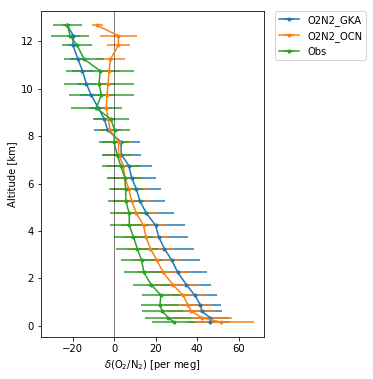

In [94]:
fig = plt.figure(figsize=(4.,6.))

ax = fig.add_subplot(111)

o2_ocn = ['O2N2_GKA', 'O2N2_OCN']

for vm in o2_ocn:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',label=vm)

sc = ax.errorbar(normalize(obs_avg.O2_AO2).values,
                 obs_avg.GGALT.values,
                 xerr=obs_std.O2_AO2.values,
                 fmt='.-',label='Obs') 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\delta$(O$_2$/N$_2$) [per meg]')
ax.set_ylabel('Altitude [km]')

plt.savefig(os.path.join(diro['fig'],'vertical-profile-o2-tracers.pdf'),
           bbox_inches='tight',dpi=300)

### did we capture zonal mean properties?

In [95]:
ds = cesm.open_casedata(case, 'atm', 'cam.h0', tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v],
                        transformed='so_ocean_mean')

ds = ds.sel(time=slice('2016-01-15','2016-02-29'))
ds = cesm.convert_dataset(ds,case)
ds = ds.isel(zlev=np.where(ds.zlev < 15e3)[0])
ds

<xarray.Dataset>
Dimensions:     (nbnd: 2, time: 45, zlev: 33)
Coordinates:
  * time        (time) object 2016-01-15 12:00:00 ... 2016-02-28 12:00:00
  * zlev        (zlev) float64 1.416e+04 1.315e+04 1.212e+04 ... 204.8 77.22
Dimensions without coordinates: nbnd
Data variables:
    O2_GKA      (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    time_bnds   (time, nbnd) float64 dask.array<shape=(45, 2), chunksize=(3, 2)>
    aO2_GKA     (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    CO2_L14C    (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    CO2_T09     (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    CO2_C15O    (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    CO2_C15L    (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    CO2_C15F    (time, zlev) float64 dask.array<shape=(45, 33), chunksize=(3, 33)>
    CO2_C15T    (time, zlev) float64 dask.array<shape=(45,

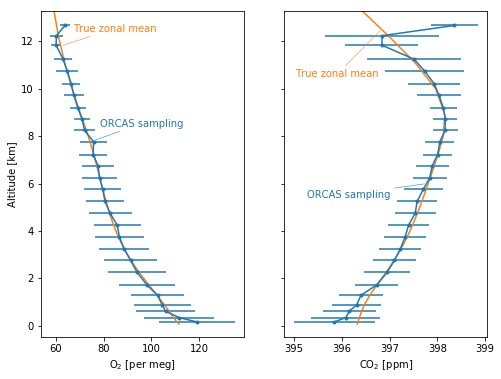

In [96]:
fig = plt.figure(figsize=(8.,6.))

vm = 'O2_OCN'
ax = fig.add_subplot(121)

sc = ax.errorbar(mdl_avg[vm].values,mdl_avg.GGALT.values,xerr=mdl_std[vm].values,fmt='.-')
xlm = ax.get_xlim()
ylm = ax.get_ylim()

p = ax.plot(ds[vm].mean(dim='time'),ds.zlev*1e-3)
ax.set_xlim(xlm)
ax.set_ylim(ylm)

ax.set_xlabel('O$_2$ [per meg]')
ax.set_ylabel('Altitude [km]')

y = 11.8
x = np.interp(y,ds.zlev[::-1]*1e-3,ds[vm].mean(dim='time')[::-1])
ax.annotate('True zonal mean', 
            xy=(x,y), 
            xytext=(x+5,y+0.6),
            color=p[0].get_color(),
            arrowprops=dict(color=p[0].get_color(),arrowstyle='-',linewidth=0.5),
            )

y = 7.8
x = np.interp(y,mdl_avg.GGALT.values,mdl_avg[vm].values)
ax.annotate('ORCAS sampling', 
            xy=(x,y), 
            xytext=(x+3,y+0.6),
            color=sc[0].get_color(),
            arrowprops=dict(color=sc[0].get_color(),arrowstyle='-',linewidth=0.5),
            )

vm = 'CO2'
ax = fig.add_subplot(122)

sc = ax.errorbar(mdl_avg[vm].values,mdl_avg.GGALT.values,xerr=mdl_std[vm].values,fmt='.-')
xlm = ax.get_xlim()
ylm = ax.get_ylim()

p = ax.plot(ds[vm].mean(dim='time'),ds.zlev*1e-3)
ax.set_xlim(xlm)
ax.set_ylim(ylm)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_yticklabels([])

y = 12.5
x = np.interp(y,ds.zlev[::-1]*1e-3,ds[vm].mean(dim='time')[::-1])
ax.annotate('True zonal mean', 
            xy=(x,y), 
            xytext=(x-1.8,y-2),
            color=p[0].get_color(),
            arrowprops=dict(color=p[0].get_color(),arrowstyle='-',linewidth=0.5),
            )

y = 6
x = np.interp(y,mdl_avg.GGALT.values,mdl_avg[vm].values)
ax.annotate('ORCAS sampling', 
            xy=(x,y), 
            xytext=(x-2.5,y-0.6),
            color=sc[0].get_color(),
            arrowprops=dict(color=sc[0].get_color(),arrowstyle='-',linewidth=0.5),
            )


plt.savefig(os.path.join(diro['fig'],'vertical-profile-zonal-representativeness.pdf'),
           bbox_inches='tight',dpi=300)

### check sum of CO2 flavors against total

The nonlinear transport means that the sum cannot be constructed exactly. 

CO$_{2}$ tracers were initialized with a constant mixing ratio of 360 ppm, thus I would expect to require that offset to match the total CO$_{2}$.  

Text(0, 0.5, '$\\sum$ CO$_2$')

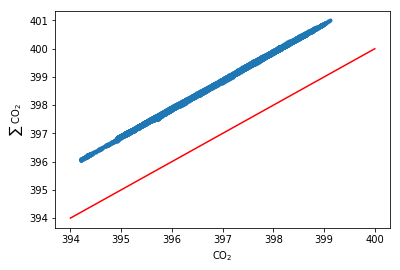

In [97]:
plt.plot(mdl.CO2,mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF+360.,'.')
plt.plot((394,400),(394,400),'r-')
plt.gca().set_xlabel('CO$_2$')
plt.gca().set_ylabel('$\sum$ CO$_2$')

That doesn't quite work.  Let's compute the optimal offset.  Why is that different from 360.?  Something to do with mass adjustment during restart?

In [98]:
offset = (mdl.CO2 - (mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF)).mean().values
offset

array(358.1190067)

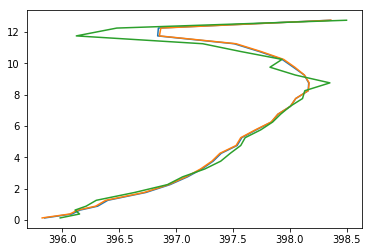

In [99]:
plt.plot(mdl_avg.CO2,mdl_avg.GGALT_bins)
plt.plot(mdl_avg.CO2_OCN+mdl_avg.CO2_FFF+mdl_avg.CO2_LND+offset,mdl_avg.GGALT_bins)
plt.plot(obs_avg.CO2_NOAA-2.,obs_avg.GGALT_bins)

In [100]:
nx0 = np.where((0.<=mdl_avg.GGALT_bins) & (mdl_avg.GGALT_bins<=2.))[0]
nx1 = np.where((5.<=mdl_avg.GGALT_bins) & (mdl_avg.GGALT_bins<=7.))[0]
print (mdl_avg.CO2[nx0].mean()-mdl_avg.CO2[nx1].mean()).values
print (obs_avg.CO2_NOAA[nx0].mean()-obs_avg.CO2_NOAA[nx1].mean()).values

<xarray.DataArray 'CO2' ()>
dask.array<shape=(), dtype=float64, chunksize=()>


AttributeError: 'NoneType' object has no attribute 'values'

In [ ]:
plt.plot(mdl.CO2,mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF+offset,'.')
plt.plot((394,400),(394,400),'r-')
plt.gca().set_xlabel('CO$_2$')
plt.gca().set_ylabel('$\sum$ CO$_2$')

### Methane distributions

Load up some data from NOAA ESRL: marine boundary layer CH4 obs.

https://www.esrl.noaa.gov/gmd/ccgg/mbl/data.php

In [ ]:
import pandas
mblch4 = pandas.read_table('data/ch4_GHGreference.664228799_zonal.txt',comment='#',header=None,
                     names=('year','month','day','decimal_date','value','uncertainty'),
                     delim_whitespace=True).to_xarray()
mblch4

Fit a harmonic function to the data: 

$y=a+b∗t+c∗cos(2\pi t+d)$

In [ ]:
from scipy.optimize import curve_fit

#-- define the function
func = lambda t,a,b,c,d: a + b * t + c * np.cos(2.*np.pi*t + d)

#-- define time axis
tmbl = mblch4.decimal_date-mblch4.decimal_date[0]

#-- fit parameters
abcd, pcov = curve_fit(func,tmbl,mblch4.value.values)

#-- just the trend
abcd_nocycle = abcd.copy()
abcd_nocycle[2:] = 0.

plt.plot(tmbl,mblch4.value,'.')
plt.plot(tmbl,func(tmbl,*abcd))
plt.plot(tmbl,func(tmbl,*abcd_nocycle))

Compute the offset necessary to match data in 2016

In [ ]:
offset = func(tmbl[np.where(mblch4.decimal_date == 2016.)[0]],*abcd_nocycle) - abcd[0]
offset.values

#### bin data by altitude and flight number

In [ ]:
alt_bins = np.concatenate((np.arange(0.,1.,0.25),np.arange(1.,14.5,0.5)))
binflt = lambda ds: ds.groupby('flt').mean()
ch4 = obs.groupby_bins('GGALT',alt_bins).apply(binflt)

Compute the date of each flight in DOY

In [ ]:
flight_date = [obs.time[np.where(obs.flt == flt)[0][0]] for flt in ch4.flt]
tch4 = np.array([(d - np.datetime64('2016-01-01')) /  np.timedelta64(1,'D') for d in flight_date])
tch4

Plot the flight data in the context of the seasonal cycle inferred from MBL data

In [ ]:
yearfrac = np.arange(0,366,1)/365.
abcd_notrend = abcd.copy()
abcd_notrend[1] = 0.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(yearfrac*365.,func(yearfrac,*abcd)+50.,label='NOAA MBL Reference')
ax.plot(tch4,ch4.CH4_NOAA.where(ch4.GGALT <= 4.).mean(dim='GGALT_bins'),'.',label='ORCAS obs (z < 4km)')

ylm = ax.get_ylim()
ax.set_xlim((12,63))
ax.set_ylim((ylm[0],1781.5))

ax.set_xlabel('Day of year')
ax.set_ylabel('CH$_4$ [ppb]')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.savefig(os.path.join(diro['fig'],'ch4-seasonal-cycle.pdf'),bbox_inches='tight')

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)

cmap = cm = plt.get_cmap('PiYG',lut=len(tch4)+1) 
cNorm  = colors.Normalize(vmin=tch4[0], vmax=tch4[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []

for i in range(len(ch4.flt)):
    colorVal = scalarMap.to_rgba(tch4[i])
    p = ax.plot(ch4.CH4_NOAA[:,i],ch4.GGALT[:,i],
                color=colorVal)

cb = plt.colorbar(scalarMap,ticks=np.arange(15,60,5))

ax.set_xlabel('CH$_4$ [ppb]')
ax.set_ylabel('Altitude [km]')

cb.ax.set_ylabel('Day of year')

plt.savefig(os.path.join(diro['fig'],'ch4-profile-by-date.pdf'),bbox_inches='tight')

### plot regional fluxes

In [ ]:
ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v],transformed='so_ocean_mean')

#ds = ds.sel(time=slice('2015-01-01','2016-02-29'))
ds = cesm.convert_dataset(ds,case)
ds = ds.isel(zlev=np.where(ds.zlev < 15e3)[0])
ds

In [ ]:
grid = xr.open_dataset('./data/f09_f09.nc')
landfrac = grid.LANDFRAC.isel(time=0)
area = grid_tools.compute_grid_area(grid.lon.values,grid.lat.values)
rmask = landfrac.where(landfrac<0.9).fillna(0.).where(landfrac>=0.9).fillna(1.).where(landfrac.lat<-44.).fillna(0.)
plt.figure()
rmask.plot()
area = rmask * area
plt.figure()
area.plot()

convert the flux fields into regional integrals in Pg C

In [ ]:
co2_ocn = ['CO2_OCN', 'CO2_T09', 'CO2_L14C',
           'CO2_T09a', 'CO2_T09b', 'CO2_T09c', 
           'CO2_T09d', 'CO2_T09e', 'CO2_T09f', 'CO2_T09g', 
           'CO2_T09h', 'CO2_T09i', 'CO2_T09j', 'CO2_T09k', 
           'CO2_T09l',  
           'CO2_CRPO', 'CO2_CROO', 'CO2_C15O']

sfint = xr.Dataset()
for v in co2_ocn:
    sfint[v] = ds['SF'+v] * area.sum() * 12.e-15
    sfint[v].attrs['units'] = 'Pg C yr$^{-1}$'

In [ ]:
sfint.CO2_OCN.plot()

### plot regional mean fluxes

In [ ]:
from datetime import datetime
import matplotlib.dates as mdates
months = mdates.MonthLocator()

fig = plt.figure()
ax = fig.add_subplot(111)

label = {}
sel = {'time':slice('2015-01-01',None)}
for vm in alt_flux_tracers:
    ax.plot(sfint.time,sfint[vm],'-',color=color[vm])

ax.axhline(0,linewidth=0.5,color='k')

ylm = ax.get_ylim()
bot = np.diff(ylm)*0.02 + ylm[0]
ax.text(pandas.Timestamp(2014,10,1),bot,'2014')
ax.text(datetime(2015,6,15),bot,'2015')
ax.text(datetime(2016,1,10),bot,'2016')

x = np.datetime64('2015-12-01')
y = np.interp(x.astype(float),sfint.time.values.astype(float),sfint.CO2_OCN.values)
ax.text(x-np.timedelta64(20,'D'),y,'CESM',
        color = color['CO2_OCN'],
        horizontalalignment='right')

x = np.datetime64('2015-12-01')
y = np.interp(x.astype(float),sfint.time.values.astype(float),
              sfint.CO2_L14C.values)
ax.text(x-np.timedelta64(30,'D'),y+0.1,'Landschutzer',
        color = color['CO2_L14C'],
        horizontalalignment='right')

x = np.datetime64('2015-09-01')
y = np.interp(x.astype(float),
              sfint.time.values.astype(float),
              sfint.CO2_T09.values)
ax.text(x-np.timedelta64(0,'D'),y+1.1,'Takahashi',
        color = color['CO2_T09'],
        horizontalalignment='center')

if 'CO2_C15O' in alt_flux_tracers:
    x = np.datetime64('2015-02-01')
    y = np.interp(x.astype(float),
                  sfint.time.values.astype(float),
                  sfint.CO2_C15O.values)
    ax.text(x-np.timedelta64(0,'D'),y-0.6,'CarbonTracker 2015',
            color = color['CO2_C15O'],
            horizontalalignment='left')

datemin = datetime(2014,8,1)
datemax = datetime(2016,2,29)
ax.set_xlim(datemin, datemax)
ax.set_ylabel('CO$_2$ flux [Pg C yr$^{-1}$]')

ax.xaxis.set_major_locator(months)
ax.set_xticklabels(['     '+d.strftime('%b')[0] for d in mdates.num2date(ax.get_xticks())])

ax.axvline(datetime(2015,1,1),linewidth=0.5,color='k')
ax.axvline(datetime(2016,1,1),linewidth=0.5,color='k')

plt.savefig(os.path.join(diro['fig'],'southern-ocean-flux-timeseries-2014-2016.pdf'))

In [ ]:
plt.plot(x,y,'.')